In [32]:
import pandas as pd 
from auviewer import lfs
import matplotlib.pyplot as plt




from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

In [33]:
df_train = pd.read_csv("/Users/qingyang/desktop/AutonLab/resuscitation-project/for_sophia/statistics.csv")

In [34]:
# Reference: Snorkel Labeling Model https://www.snorkel.org/use-cases/01-spam-tutorial

# Define the label mappings for convenience
ABSTAIN = -1
INSUFFICIENT = 0
SUFFICIENT = 1

In [35]:
# ART_mean_lower = getattr(lfs, "ART_mean_lower", None)
# SvO2_mean_lower = getattr(lfs, "SvO2_mean_lower", None)

In [38]:
from snorkel.labeling import labeling_function

In [49]:
@labeling_function()
def ART_mean_lower(pig):
    if pig['ART_mean [5 min]'] >= 60:
        return SUFFICIENT
    else:
        return ABSTAIN

@labeling_function()
def ART_mean_higher(pig):
    if pig['ART_mean [5 min]'] <= 70:
        return ABSTAIN
    else:
        return SUFFICIENT

@labeling_function()
def SvO2_mean_higher(pig):
    if pig['SvO2_mean [2 min]'] <= 65:
        return SUFFICIENT
    else:
        return ABSTAIN

@labeling_function()
def SvO2_mean_lower(pig):
    if pig['SvO2_mean [2 min]'] >= 60:
        return SUFFICIENT
    else:
        return ABSTAIN

In [50]:
lfs_list = [ART_mean_lower, ART_mean_higher, SvO2_mean_higher, SvO2_mean_lower]

In [51]:
df_train.head()

,Unnamed: 0,pigID,timestamp,ART_mean [2 min],ART_mean [5 min],SvO2_mean [2 min],SvO2_mean [5 min]
0,2433690,32,1.652986e+09,34.344871,34.785974,30.109299,30.307672
1,2448690,32,1.652987e+09,34.620191,34.656330,29.932412,30.186230
2,2463690,32,1.652987e+09,36.465104,35.205380,30.700268,30.382626
3,2478690,32,1.652987e+09,39.664165,36.610467,32.275945,30.920219
4,2493690,32,1.652987e+09,43.070364,38.655412,33.600209,31.727034


In [52]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs_list)
L_train = applier.apply(df_train)
# L_train: label matrix, L[i, j] is the label that the jth labeling function output for the ith data point



100%|██████████| 214/214 [00:00<00:00, 85183.74it/s]


In [53]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
df_train["snorkel_label"] = label_model.predict(L=L_train, tie_break_policy="abstain")

100%|██████████| 500/500 [00:00<00:00, 3202.97epoch/s]


In [55]:
df_train.head(100)

,Unnamed: 0,pigID,timestamp,ART_mean [2 min],ART_mean [5 min],SvO2_mean [2 min],SvO2_mean [5 min],snorkel_label
0,2433690,32,1.652986e+09,34.344871,34.785974,30.109299,30.307672,0
1,2448690,32,1.652987e+09,34.620191,34.656330,29.932412,30.186230,0
2,2463690,32,1.652987e+09,36.465104,35.205380,30.700268,30.382626,0
3,2478690,32,1.652987e+09,39.664165,36.610467,32.275945,30.920219,0
4,2493690,32,1.652987e+09,43.070364,38.655412,33.600209,31.727034,0
...,...,...,...,...,...,...,...,...
95,3858690,32,1.652992e+09,79.393113,76.973795,68.156056,66.521321,1
96,3873690,32,1.652992e+09,78.537378,78.007428,68.726885,67.488782,1
97,3888690,32,1.652992e+09,76.047668,77.695247,68.531676,68.113798,1
98,3903690,32,1.652992e+09,73.086434,76.429883,67.871304,68.135891,1


In [77]:
if "normalized_t [min]" not in df_train:
    df_train.insert(loc = 1, column = "normalized_t [min]", value = df_train["timestamp"] - df_train["timestamp"][0])

In [78]:
df_train["normalized_t [min]"] = df_train["normalized_t [min]"] / 60

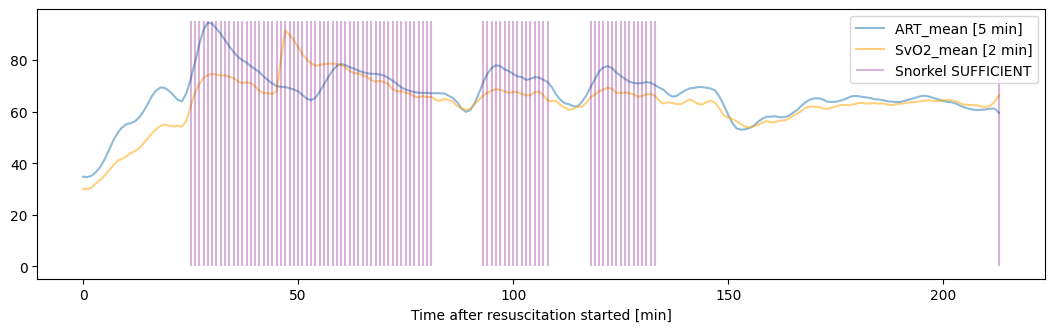

In [85]:
plt.figure(figsize=(13, 3.5))
plt.plot(df_train["normalized_t [min]"], df_train["ART_mean [5 min]"], color="C0", alpha=0.5, label="ART_mean [5 min]") # raw time series, 250Hz
plt.plot(df_train["normalized_t [min]"], df_train["SvO2_mean [2 min]"], color="orange", alpha=0.5, label="SvO2_mean [2 min]")

# plt.scatter(df_train["timestamp"][(df_train.snorkel_label == 1)], df_train["snorkel_label"][(df_train.snorkel_label == 1)], color="red", s=5)
plt.vlines(df_train["normalized_t [min]"][(df_train.snorkel_label == 1)], 0, 95, color="purple", alpha=0.3, label='Snorkel SUFFICIENT')
plt.legend()
plt.xlabel("Time after resuscitation started [min]")
# plt.ylabel("SvO2_mean [2 min]  ART_mean [5 min]")
plt.show()